In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [51]:
df = pd.read_csv('MSN.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
12/25/2017 9:15,MSN,73.1,73.1,73.1,73.1,4210,0
12/25/2017 9:16,MSN,73.0,73.0,73.0,73.0,5000,0
12/25/2017 9:18,MSN,73.5,73.5,73.5,73.5,210,0
12/25/2017 9:20,MSN,73.2,73.5,73.1,73.1,2050,0
12/25/2017 9:21,MSN,73.0,73.0,73.0,73.0,1380,0


In [52]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.resample('12H').mean().dropna()
df.head()

,Close
Date/Time,
2017-12-25 00:00:00,73.492308
2017-12-25 12:00:00,74.087755
2017-12-26 00:00:00,74.866667
2017-12-26 12:00:00,74.924561
2017-12-27 00:00:00,75.274026


In [53]:
scaler = MinMaxScaler(feature_range=(0,1))
df_Close_scaled = scaler.fit_transform(np.array(df.Close).reshape(-1,1))
df_Close_scaled.shape

(1494, 1)

In [54]:
train_size = int(len(df_Close_scaled)*0.65)
test_size = len(df_Close_scaled) - train_size
train_data,test_data = df_Close_scaled[0:train_size,:],df_Close_scaled[train_size:len(df_Close_scaled),:1]

In [55]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [56]:
time_step = 100
X_train, y_train =  create_dataset(train_data,time_step)
X_test, y_test =  create_dataset(test_data,time_step)

In [57]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(y_test.shape)

(870, 100)
[[0.38559563 0.39416312 0.40537035 ... 0.69295457 0.68969446 0.68400709]
 [0.39416312 0.40537035 0.40620336 ... 0.68969446 0.68400709 0.68015578]
 [0.40537035 0.40620336 0.41123157 ... 0.68400709 0.68015578 0.67618227]
 ...
 [0.45835324 0.46774615 0.46604669 ... 0.21122104 0.20970513 0.21123664]
 [0.46774615 0.46604669 0.46474707 ... 0.20970513 0.21123664 0.21003942]
 [0.46604669 0.46474707 0.46314934 ... 0.21123664 0.21003942 0.22533784]]
(422, 100)
(422,)


In [58]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model .add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50))
model .add(Dropout(0.2))

model .add(Dense(units = 1))

model .compile(optimizer = 'adam', loss = 'mean_squared_error')

In [59]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_12 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_13 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_14 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_14 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

In [60]:
model.fit(X_train, y_train,epochs = 100, batch_size = 64,verbose = 1)

Epoch 1/100
14/14 [==============================] - 10s 28ms/step - loss: 0.1171
Epoch 2/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0172
Epoch 3/100
14/14 [==============================] - 0s 23ms/step - loss: 0.0104
Epoch 4/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0085
Epoch 5/100
14/14 [==============================] - 0s 25ms/step - loss: 0.0086
Epoch 6/100
14/14 [==============================] - 0s 26ms/step - loss: 0.0071
Epoch 7/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0069
Epoch 8/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0065
Epoch 9/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0073
Epoch 10/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0063
Epoch 11/100
14/14 [==============================] - 0s 17ms/step - loss: 0.0057
Epoch 12/100
14/14 [==============================] - 0s 16ms/step - loss: 0.0060
Epoch 13/100
14/14 [====

In [61]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

14/14 [==============================] - 0s 7ms/step


In [62]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [63]:
print(np.mean((y_train - train_predict)**2))
print(np.mean((y_test  - test_predict)**2))

7231.837091651246
3945.1059085210604


In [64]:
look_back = 100

In [65]:
trainPredictPlot = np.empty_like(df_Close_scaled)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [66]:
testPredictPlot = np.empty_like(df_Close_scaled)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df_Close_scaled) - 1,:] = test_predict

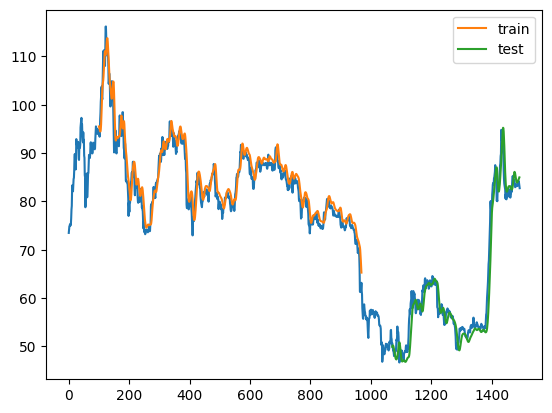

In [67]:
plt.plot(scaler.inverse_transform(df_Close_scaled))
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend()
plt.show()